# Projet:  
- Réalisation d'une ApplicationDasboard avec Streamlit  
à partir de base de données open source sur les transactions 
de cartes de crédits.
- Lien web vers la source des données:  
[credits_cards_transactions](https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset)
- Objectif de notre dasboard:  
Construire un dashboard qui des indicateurs  

## Importation des librairies

- Installation des librairies:  
Exécuter dans la cellule:  %pip install -r requirements.txt  
ou  
Exécuter dans le terminal (prompt ou powershell):  pip install -r requirements.txt

- Importation des librairies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import random
import warnings 
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",100)
random.seed(123)

## Chargement des données

In [ ]:
# Fonction pour charger les données

def load(file:str, size:int = 10**5, sep:str = ','):
    """--Docstring--
    fonction pour charger les données csv
    tout en optimisant la mémoire du système
    avec les fichiers volumineux. L'option
    size permet de charger les données par
    partition.
    Args:
        file: (string, file.csv or path )
        size: taille de la partition (integer, default = 100000)
              si la mémoire est insuffisante pour importer en un
              bloc.
        sep: séparateur (string, default = <,>)
    """

    try:

        data = pd.read_csv(file, sep=sep, index_col=0)
    
    except MemoryError:

        data = pd.read_csv(file, sep=sep, index_col=0,
                            chunksize = size)
    
    data.index.name = 'index'
    
    return data


In [ ]:
# Chargement des données
path = "credit_card_transactions.csv"
financial_data = load(path) 

## Exploration des données

In [ ]:
financial_data.head(5)

In [ ]:
## Selection & détection des valeurs manquantes 
financial_data.isnull()

In [ ]:
#Nombre de valeurs manquantes par colonnes 
financial_data.isnull().sum() 

## Transporer le DF pour une bonne analyse 
financial_data.describe().transpose()

### description sur les types de variables

In [ ]:
# Fonction pour décrire le dataframe
    
dictionnaire = {
    'trans_date_trans_time': 'Horodatage format date de la transaction',
    'cc_num': 'Numéro de carte de crédit',
    'merchant': 'Nom du commerce',
    'category' : 'Catégorie de la transaction, exemple: achat épicerie',
    'amt' : 'Montant de la transaction',
    'first': 'Prénom du titulaire de la carte',
    'last': 'Nom de famille du titulaire de la carte',
    'gender' : 'Sexe du titulaire de la carte',
    'street' : 'Rue du titulaire de la carte', 
    'city' :  'Ville du titulaire de la carte', 
    'state' : 'Etat du titulaire de la carte',
    'zip' : 'Code postale du titulaire de la carte', 
    'lat' : "Latitude du lieu d'achat de la transaction",
    'long' : "Longitude du lieu d'achat de la transaction",  
    'city_pop' : 'Population de la ville où la transaction a eu lieu',
    'job' : 'Profession du titulaire de la carte',
    'dob' : 'Date de naissance du titulaire de la carte',
    'trans_num' : 'Numéro de transaction unique',
    'unix_time' : 'Horodatage format Unix de la transaction',
    'merch_lat' : 'Latitude de la position du commerçant',  
    'merch_long': "Longitude de la position du commerçant", 
    'is_fraud' : 'Indicateur indiquant si la transaction est frauduleuse',
    'merch_zipcode' : 'Code postal du commerçant'
    }

def info(data):

    Information = pd.DataFrame({
        'Variables': data.columns,
        'Type': data.dtypes,
        'Unique_values': data.nunique(),
        'NA_counts': data.isna().sum(),
        'NA_percent%':data.isna().mean().round(4)*100,
        }).reset_index(drop=True)

    Information['Description_des_variables'] = Information['Variables'].map(dictionnaire)
    
    return Information

# Application sur financial_data
info(financial_data)

### mise en forme du type des variables

In [ ]:
# fonction pour mettre en forme

def conversion(var):

    # conversion des variables de type = <date>
    date_vars = ('trans_date_trans_time', 'dob')

    if var.name in date_vars:
        
        return pd.to_datetime(var, infer_datetime_format = True)


    # conversion des variables type = <objet>
    if (var.dtype=='object') and (var.name not in date_vars):

        # conversion en string
        if var.nunique() > 20:
            return var.astype('string')

        # conversion en catégorie 
        else:
            return var.astype('category')
    
    else:
        return var 


In [ ]:
# application de la fonction sur les variables 
financial_data = financial_data.apply(conversion, axis = 0)

### Création de nouvelles variables

- Variables dates

In [ ]:
# mettre la variable trans_date_... au format '2020-01-31'
# avec une nouvelle variable

financial_data['date_transaction'] = pd.to_datetime(financial_data['trans_date_trans_time']
                                                                  .dt.strftime('%d-%b-%Y'))

# Extraire les périodes sur les transactions : jour, semaine de l'année, mois, heure

financial_data['year_transaction'] = (financial_data['trans_date_trans_time']
                                                   .dt.year)

financial_data['day_transaction'] = (financial_data['trans_date_trans_time']
                                                   .dt.day_name.astype('category'))

financial_data['week_transaction'] = financial_data['date_transaction'].dt.isocalendar().week

financial_data['month_transaction'] = (financial_data['trans_date_trans_time']
                                                   .dt.month_name().astype('category'))

financial_data['hour_transaction'] = (financial_data['trans_date_trans_time']
                                                   .dt.strftime('%H.%M')).astype(float)

# Créer une variable moment de la journée à partir de heure_transaction

condlist = [financial_data['hour_transaction'].between(6,12.59),
            financial_data['hour_transaction'].between(13,18.59),
            financial_data['hour_transaction'].between(19,23.59),
            financial_data['hour_transaction'].between(0,5.59)
            ]
choicelist = ['Morning: 6h-12h59',
              'Afternoon: 13h-18h59',
              'Evening: 19h-23h59',
              'Night: 00h-5h59'
              ]

financial_data['moment_transaction'] = np.select(condlist, choicelist, default=None)
financial_data['moment_transaction'] = financial_data['moment_transaction'].astype('category')

- Variables Âge, Nom

In [ ]:
# Définir la date de référence pour le calcul de l'âge
reference_date = pd.to_datetime('2020-12-31')

# Calcul de l'âge de l'individu à partir de la date de naissance (dob) 
financial_data['age'] = ((reference_date - financial_data['dob']).dt.days/365).astype('int')

# Création de la variable groupe d'âge
financial_data['group_age']=pd.cut(financial_data['age'],
                                   bins=[14,31,46,60,100],
                                   labels=['15-30 ans', '31-45 ans','46-60 ans' ,'+60 ans']
                                  ).astype('category')

# Concaténer first(prénom) et last(nom_de_famille) pour avoir
# nom complet
financial_data['fullname'] = (financial_data['first'] +' '+ financial_data['last']).astype('string')

### Création de la base de données individuelles
- calcul du montant journalier des transactions individuelles 'daily_amount$'
- calcul du nombre de fraudes individuelles constaté sur la carte de crédits 'daily_fraud'
- calcul du montant de perte subi par l'individu sur les fraudes journalières: daily_fraud_cost$ 
- extraction des variables:  
['fullname','age', 'job','city','daily_amount$','daily_fraud', 'daily_fraud_cost$',  
'date_transaction', 'week_transaction', 'month_transaction', 'year_transaction']

In [ ]:
# liste des variables pour les aggrégations
agglist = ['fullname','date_transaction']

# Calcul du montant journalier des transactions
# par personne
financial_data['daily_amount$'] = financial_data.groupby(agglist)['amt'].transform('sum')

# Calcul du nombre de fraude journalier sur les transactions 
# par personne
financial_data['daily_fraud'] = financial_data.groupby(agglist)['is_fraud'].transform('sum')

# Calcul du cout = montant journalier des fraudes sur transactions 
# par personne
financial_data['daily_fraud_cost$'] = (financial_data[financial_data['is_fraud']==1]
                                                            .groupby(agglist)['amt']
                                                            .transform('sum')
                                      )
financial_data['daily_fraud_cost$'].fillna(0, inplace = True)

liste = ['date_transaction', 'week_transaction', 'month_transaction', 'year_transaction',
         'fullname','age', 'job','state','city','daily_amount$','daily_fraud','daily_fraud_cost$']

# Création du dataframe individus
individual_data = (financial_data[liste].drop_duplicates(subset = agglist, ignore_index = True)
                                        .sort_values(by=agglist, ignore_index = True)
                    )
# Exportation des données au format csv
individual_data.to_csv('individual_data.csv', index = False)

# Affichage des données
individual_data.head(60)

### Création de la base de données Etat-villes: state_city_data
- calcul du montant journalier des transactions par ville pour chaque état: 'daily_amountUSD'
- calcul du nombre de fraudes journaliers par ville pour chaque état: 'daily_fraud'
- calcul du montant de perte subi par ville sur les fraudes journalières: daily_fraud_cost$
- extraction des variables:  
['state','city','city_pop','daily_amount$','daily_fraud', 'daily_fraud_cost$'
 'date_transaction', 'week_transaction', 'month_transaction', 'year_transaction']

In [ ]:
# liste des variables dates pour les aggrégations
agglist = ['city','date_transaction', ]

liste = ['date_transaction', 'week_transaction', 'month_transaction', 'year_transaction',
         'state','city','city_pop','daily_amount$','daily_fraud', 'daily_fraud_cost$']

# Calcul du montant journalier des transactions
# par ville pour chaque Etat
financial_data['daily_amount$'] = financial_data.groupby(agglist)['amt'].transform('sum')

# Calcul du nombre de fraude journalier sur les transactions 
# par ville pour chaque Etat
financial_data['daily_fraud'] = financial_data.groupby(agglist)['is_fraud'].transform('sum')

# Calcul du cout = montant journalier des fraudes sur transactions 
# par ville pour chaque Etat
financial_data['daily_fraud_cost$'] = (financial_data[financial_data['is_fraud']==1]
                                                            .groupby(agglist)['amt']
                                                            .transform('sum')
                                      )
financial_data['daily_fraud_cost$'].fillna(0, inplace = True)

# Création du dataframe Etats/Villes
statecity_data = (financial_data[liste].drop_duplicates(subset = agglist, ignore_index = True)
                                        .sort_values(by=['state', 'city', 'date_transaction'],
                                                     ignore_index = True)
                    )
# exporttaion au format csv
statecity_data.to_csv('statecity_data.csv', index = False)

# Affichage des données
statecity_data[statecity_data['daily_fraud'] > 0].head(60)


## Analyse Statistique des données

- fonction pour tableau Croisé de Statistiques descriptives

In [ ]:
def cross_stat(data:pd.DataFrame, catlist:list, statvars:list):

    """--Docstring--
    fonction pour réaliser des statistiques
    sur des variables croisées.
    
    Args:
         data: le dataframe
         catlist: (list) variables catégorielles
         statvars: (list) variables continues
    
    return a dataframe
    """
    # initialisation d'un tableau vide
    table = pd.DataFrame()
    
    # Création de dictionnaire pour les indexes
    index_mapping = {value: cat for cat in catlist for value in data[cat].unique()}

    
    for var in statvars:

        for cat in catlist:
            
            X = data.groupby(by=cat)[var].agg(min = 'min',
                                              max = 'max',
                                              mean = 'mean',
                                              st_deviation = 'std',
                                              quartile1 = lambda x: x.quantile(0.25),
                                              median = 'median',
                                              quartile3 = lambda x: x.quantile(0.75),
                                              category_size = 'count')

            table = pd.concat([table,X], axis = 0, ignore_index = False)
    
        table.reset_index(names = 'valeurs', inplace = True)
        table['Categories'] = table['valeurs'].map(index_mapping)
        table.set_index(['Categories','valeurs'], inplace = True)
    
        print(f'Tableau Statistiques croisées sur: {var}')
        display(table.round(2))
        print('\n\n')


In [77]:
#Informations liées à la colonne amount 

#simplifier la notation
pd.options.display.float_format = '{:.2f}'.format

print(df['amt'].describe())

count   1296675.00
mean         70.35
std         160.32
min           1.00
25%           9.65
50%          47.52
75%          83.14
max       28948.90
Name: amt, dtype: float64


Suppression de la colonne merch_zipcode  qui contient des  valeurs manquantes assez important et n'est assez pertinents pour nos 
analyses a venir

In [ ]:
transaction_data = transaction_data.drop(columns=['merch_zipcode'])
print("colonne merch_zipcode supprimé")

Gestion des données manquantes

In [ ]:
# Vérification du nombre de valeurs manquantes par colonnes

# ici avec le .isna j'identifie les valeurs manquantes par colonnes et apres je fait leur somme par colonne avec le .sum

nombre_de_valeurs_manquantes = transaction_data.isna().sum()

print(f"le nombre total des valeurs manquantes par colonnes est : { nombre_de_valeurs_manquantes}")

In [78]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
count = df['trans_date_trans_time'].dt.year.value_counts()
print("Informations liées à la colonne", count,"\n")

count = df['gender'].value_counts()
print("Informations liées à la colonne", count,"\n")

count = df['category'].value_counts()
print("Informations liées à la colonne", count,"\n")

count = df['merchant'].value_counts()
print("Informations liées à la colonne", count,"\n")

count = df['city'].value_counts()
print("Informations liées à la colonne", count,"\n")

count = df['state'].value_counts()
print("Informations liées à la colonne", count,"\n")

count = df['job'].value_counts()
print("Informations liées à la colonne", count,"\n")

df['dob'] = pd.to_datetime(df['dob'])
count = df['dob'].dt.year.value_counts()
print("Informations liées à la colonne", count,"\n")

count = df['is_fraud'].value_counts()
print("Informations liées à la colonne", count,"\n")

Informations liées à la colonne trans_date_trans_time
2019    924850
2020    371825
Name: count, dtype: int64 

Informations liées à la colonne gender
F    709863
M    586812
Name: count, dtype: int64 

Informations liées à la colonne category
gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: count, dtype: int64 

Informations liées à la colonne merchant
fraud_Kilback LLC                       4403
fraud_Cormier LLC                       3649
fraud_Schumm PLC                        3634
fraud_Kuhn LLC                          3510
fraud_Boyer PLC                         3493
                                        ... 
fraud_Douglas, DuBuque and McKenzie      775
fraud_Treutel-King    

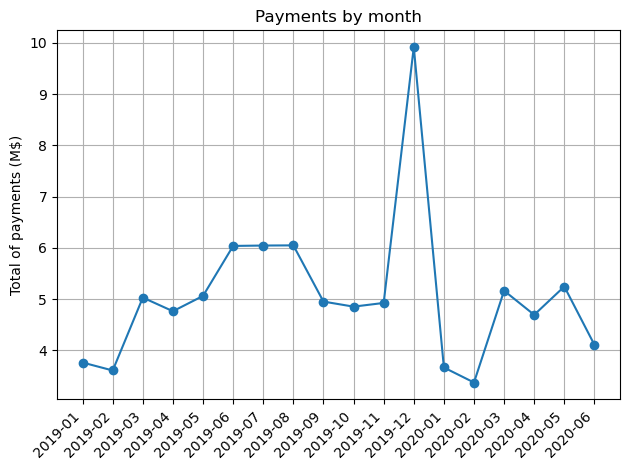

In [ ]:
# Nombre de paiements par mois 


df['amt_M'] = df['amt'] / 1000000

# Regrouper et sommer par année et par montant
amt_sum_by_year = df.groupby(['year'])['amt_M'].sum()
amt_sum_by_month = df.groupby(['year_month'])['amt_M'].sum()

# Afficher les résultats
# print("Montants totaux par année :\n\n", amt_sum_by_year, "\n")
# print("Montants totaux par mois :\n\n", amt_sum_by_month, "\n")


# Tracer les données
plt.plot(amt_sum_by_month.index.astype(str), amt_sum_by_month.values, marker='o', linestyle='-')

# Ajouter des titres et des labels
plt.ylabel('Total of payments (M$)')
plt.title('Payments per month')
plt.xticks(rotation=45, ha='right')  # Améliore la lisibilité des mois
plt.grid(True)
plt.tight_layout()
plt.show()



Observations : 
-18 mois de données
-max en décembre
-min en février 

Montant de paiements moyens en fonction des categories :

 category
entertainment     64.21
food_dining       51.09
gas_transport     63.43
grocery_net       53.67
grocery_pos      116.96
health_fitness    54.18
home              58.27
kids_pets         57.54
misc_net          80.87
misc_pos          62.89
personal_care     47.97
shopping_net      88.42
shopping_pos      79.78
travel           111.50
Name: amt, dtype: float64 



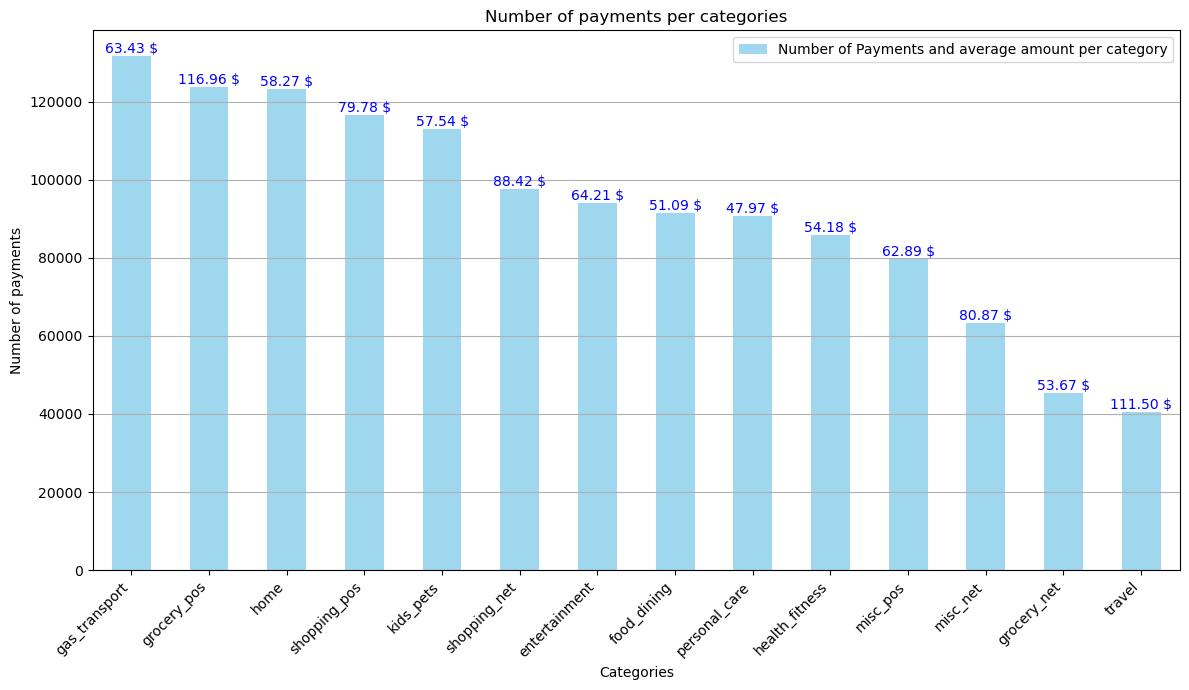

In [163]:
# Nombre de paiement en fonction de la CATEGORY

# Grouper par mois, et compter les occurrences
category_sum = df.groupby('category').size().sort_values(ascending=False)
# category_sum_by_month = df.groupby(['year_month', 'category']).size().unstack(fill_value=0)

# Calculer le paiement moyen par catégorie
avg_payment_per_category = df.groupby('category')['amt'].mean()

# Afficher le résultat
# print("Nombre de paiements en fonction des categories :\n\n", category_sum,"\n")
print("Montant de paiements moyens en fonction des categories :\n\n", avg_payment_per_category,"\n")


# Tracer un histogramme pour le nombre de paiements par catégorie
fig, ax1 = plt.subplots(figsize=(12, 7))

# Tracé des paiements par catégorie
category_sum.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)

# Ajouter les paiements moyens en tant qu'annotations sur les barres
for i, category in enumerate(category_sum.index):
    ax1.text(i, category_sum[category], f'{avg_payment_per_category[category]:.2f} $', 
             ha='center', va='bottom', color='blue', fontsize=10)
    
# Configuration du graphique
plt.xlabel('Categories')
plt.ylabel('Number of payments')
plt.title('Number of payments per categories')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

ax1.legend(['Number of Payments and average amount per category'], loc='upper right')


plt.tight_layout()
plt.show()

In [ ]:
# Nombre de paiement en fonction du STATE

# Calcul de la somme et tri par ordre décroissant
state_sum = df.groupby('state').size().sort_values(ascending=False)


# Calculer le paiement moyen par state
avg_payment_per_state = df.groupby('state')['amt'].mean()

# Afficher le résultat
# print("Nombre de paiements en fonction des categories :\n\n", category_sum,"\n")
# print("Montant de paiements moyens en fonction des categories :\n\n", avg_payment_per_state,"\n")


# Tracer un histogramme pour le nombre de paiements par catégorie
fig, ax1 = plt.subplots(figsize=(20, 7))

# Tracé des paiements par catégorie
state_sum.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)

# Ajouter les paiements moyens en tant qu'annotations sur les barres
for i, state in enumerate(state_sum.index):
    ax1.text(i, state_sum[state], f'{avg_payment_per_state[state]:.2f} $', 
             ha='center', va='bottom', color='blue', fontsize=6)
    
# Configuration du graphique
plt.xlabel('State')
plt.ylabel('Number of payments')
plt.title('Number of payments per state')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

ax1.legend(['Number of Payments and average amount per state'], loc='upper right')


plt.tight_layout()
plt.show()

In [81]:
# Nombre de paiement en fonction du JOB

# Grouper par mois, et compter les occurrences
job_sum_by_year = df.groupby(['year', 'job']).size().unstack(fill_value=0)
job_sum_by_month = df.groupby(['year_month', 'job']).size().unstack(fill_value=0)

# Afficher le résultat
# print("Nombre de paiements en fonction du JOB :\n\n", job_sum_by_year,"\n")
# print(job_sum_by_month)

In [82]:
import json
# Fonction pour trouver l'emmeteur de la carte bancaire



# Charger le JSON
with open(r"C:\Users\Ilies\Desktop\Data\SDA (N.MOUMMOU)\Projet\iin_ranges.json", "r") as file:
    iin_data = json.load(file)


def get_issuer(card_number):
    for network, ranges in iin_data["networks"].items():
        for iin_range in ranges:
            if "-" in iin_range:
                start, end = map(int, iin_range.split("-"))
                if start <= int(card_number[:len(str(start))]) <= end:
                    return network
            else:
                if card_number.startswith(iin_range):
                    return network
    return "Unknown Issuer Network"

# # # Entrée utilisateur
# card_number = input("Entrez les 6 premiers chiffres de la carte : ").strip()

# # Vérification et affichage
# issuer = get_issuer(card_number)
# print(f"Le réseau émetteur est : {issuer}")

In [83]:
# Convertir les nombres en chaînes sans notation scientifique
df['cc_num'] = df['cc_num'].apply(lambda x: f"{int(x):.0f}")

# Récupérer les 4 premiers chiffres
first_6_digits= df['cc_num'].str[:6]

# Afficher le DataFrame
print(first_6_digits)


0          270318
1          630423
2          388594
3          353409
4          375534
            ...  
1296670    302635
1296671    601114
1296672    351486
1296673    272001
1296674    429290
Name: cc_num, Length: 1296675, dtype: object


In [84]:
df['iin'] = first_6_digits.apply(get_issuer)

Nombre de paiements frauduleux :

 is_fraud       0     1
year                  
2019      919630  5220
2020      369539  2286 

is_fraud         0    1
year_month             
2019-01      52019  506
2019-02      49349  517
2019-03      70445  494
2019-04      67702  376
2019-05      72124  408
2019-06      85710  354
2019-07      86265  331
2019-08      86977  382
2019-09      70234  418
2019-10      68304  454
2019-11      70033  388
2019-12     140468  592
2020-01      51859  343
2020-02      47455  336
2020-03      72406  444
2020-04      66590  302
2020-05      73816  527
2020-06      57413  334


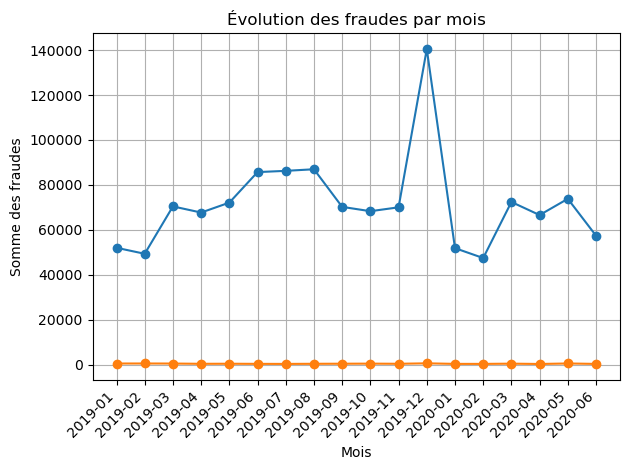

In [109]:
# Nombre de paiement frauduleux
# Grouper par mois, et compter les occurrences
fraud_sum_by_year = df.groupby(['year', 'is_fraud']).size().unstack(fill_value=0)
fraud_sum_by_month = df.groupby(['year_month', 'is_fraud']).size().unstack(fill_value=0)

# Afficher le résultat
print("Nombre de paiements frauduleux :\n\n", fraud_sum_by_year,"\n")
print(fraud_sum_by_month)



# Tracer les données
plt.plot(fraud_sum_by_month.index.astype(str), fraud_sum_by_month.values, marker='o', linestyle='-')

# Ajouter des titres et des labels
plt.xlabel('Mois')
plt.ylabel('Somme des fraudes')
plt.title('Évolution des fraudes par mois')
plt.xticks(rotation=45, ha='right')  # Améliore la lisibilité des mois
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:


# Assurez-vous que 'year_month' est présent dans le DataFrame
df['year_month'] = df['trans_date_trans_time'].dt.to_period('M').astype(str)

# Grouper par year_month et is_fraud
fraud_counts = df[df['is_fraud'] == 1].groupby('year_month').size()
non_fraud_counts = df[df['is_fraud'] == 0].groupby('year_month').size()

# Remplir les périodes manquantes avec 0 pour assurer un alignement correct
all_months = df['year_month'].sort_values().unique()
fraud_counts = fraud_counts.reindex(all_months, fill_value=0)
non_fraud_counts = non_fraud_counts.reindex(all_months, fill_value=0)

# Création des subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Graphique pour is_fraud = 1
ax1.bar(fraud_counts.index, fraud_counts.values, color='salmon', alpha=0.8)
ax1.set_title('Number of Fraudulent Payments (is_fraud = 1)', fontsize=14)
ax1.set_ylabel('Count', fontsize=12)
ax1.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Graphique pour is_fraud = 0
ax2.bar(non_fraud_counts.index, non_fraud_counts.values, color='skyblue', alpha=0.8)
ax2.set_title('Number of Non-Fraudulent Payments (is_fraud = 0)', fontsize=14)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_xlabel('Year-Month', fontsize=12)
ax2.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Ajustement des ticks
plt.xticks(rotation=45, ha='right')

# Ajustement global
plt.tight_layout()
plt.show()


In [86]:
# isfraud1_df = df[df['is_fraud'] == 1][['iin', 'trans_date_trans_time']]

# print(isfraud1_df)

In [87]:
# unknown_count = (isfraud1_df['iin'] == 'Unknown Issuer Network').sum()

# print(f"Nombre de 'Unknown Issuer Network' : {unknown_count} \n\n")

# unknown_fraud = df[(df['iin'] == 'Unknown Issuer Network') & (df['is_fraud'] == 1)][['cc_num', 'trans_date_trans_time']]

# print(unknown_fraud)


In [88]:
# print("Paiements frauduleux par liste d'émetteur")
# isfraud1_df['iin'].value_counts()


In [89]:
print("Total des paiements par liste d'émetteur")
df['iin'].value_counts()

Total des paiements par liste d'émetteur


iin
Visa                        418816
JCB                         288558
Diners Club Intl            125985
American Express            123834
Discover Card               105436
Mastercard                   88287
Maestro                      47362
UATP                         39893
GPN                          21524
Laser                        17883
Diners Club USA & Canada      8278
InstaPayment                  5641
Maestro UK                    5169
Switch                           9
Name: count, dtype: int64

In [ ]:
print("Total des paiements par liste d'émetteur")
print(df['iin'].value_counts())



# Nombre de paiement en fonction de la liste d'emmeteur

# Grouper par mois, et compter les occurrences
iin_sum = df.groupby('iin').size().sort_values(ascending=False)
# category_sum_by_month = df.groupby(['year_month', 'category']).size().unstack(fill_value=0)

# Calculer les paiements frauduleux par liste d'émetteur
fraud_iin_sum = df[df['is_fraud'] == 1].groupby('iin').size()
fraud_iin_percentage = (fraud_iin_sum / iin_sum) * 100

# Calculer le paiement moyen par catégorie
avg_payment_per_iin = df.groupby('iin')['amt'].mean()

# Afficher le résultat
# print("Nombre de paiements en fonction des categories :\n\n", category_sum,"\n")
# print("Montant de paiements moyens en fonction des categories :\n\n", avg_payment_per_category,"\n")


# Tracer un histogramme pour le nombre de paiements par catégorie
fig, ax1 = plt.subplots(figsize=(12, 7))

# Tracé des paiements par catégorie
iin_sum.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)


# Ajouter les paiements moyens en tant qu'annotations sur les barres
for i, iin in enumerate(iin_sum.index):
    ax1.text(i, iin_sum[iin], f'{fraud_iin_percentage[iin]:.2f} %', 
             ha='center', va='bottom', color='red', fontsize=10)
    
# Configuration du graphique
plt.xlabel('IIN')
plt.ylabel('Number of payments')
plt.title('Number of payments per IIN')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

ax1.legend(['Number of Payments and fraud percentage per IIN'], loc='upper right')


plt.tight_layout()
plt.show()



In [ ]:
# Crée une fonction pour mapper les groupes
def map_iin_group(iin):
    if iin in ['Discover Card', 'Diners Club Intl', 'Diners Club USA & Canada']:
        return 'Discover Financial Services'
    elif iin in ['Mastercard', 'Maestro', 'Maestro UK', 'Switch']:
        return 'Mastercard Group'
    else:
        return iin

# Appliquer la fonction à une nouvelle colonne
df['iin_group'] = df['iin'].apply(map_iin_group)

iin_sum = df.groupby('iin_group').size().sort_values(ascending=False)



# Calculer les paiements frauduleux par liste d'émetteur
fraud_iin_sum = df[df['is_fraud'] == 1].groupby('iin_group').size()
fraud_iin_percentage = (fraud_iin_sum / iin_sum) * 100

# Calculer le paiement moyen par catégorie
avg_payment_per_iin = df.groupby('iin_group')['amt'].mean()

# Afficher le résultat
# print("Nombre de paiements en fonction des categories :\n\n", category_sum,"\n")
# print("Montant de paiements moyens en fonction des categories :\n\n", avg_payment_per_category,"\n")


# Tracer un histogramme pour le nombre de paiements par catégorie
fig, ax1 = plt.subplots(figsize=(12, 7))

# Tracé des paiements par catégorie
iin_sum.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)


# Ajouter les paiements moyens en tant qu'annotations sur les barres
for i, iin_group in enumerate(iin_sum.index):
    ax1.text(i, iin_sum[iin_group], f'{fraud_iin_percentage[iin_group]:.2f} %', 
             ha='center', va='bottom', color='red', fontsize=10)
    
# Configuration du graphique
plt.xlabel('IIN')
plt.ylabel('Number of payments')
plt.title('Number of payments per IIN')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

ax1.legend(['Number of Payments and fraud percentage per IIN'], loc='upper right')


plt.tight_layout()
plt.show()



In [90]:
fraud_df = df[['year','month','day','dayname','hour', 'iin','amt' ,'is_fraud']]
fraud_df

,year,month,day,dayname,hour,iin,amt,is_fraud
0,2019,1,1,Tuesday,0,Mastercard,4.97,0
1,2019,1,1,Tuesday,0,Laser,107.23,0
2,2019,1,1,Tuesday,0,Diners Club Intl,220.11,0
3,2019,1,1,Tuesday,0,JCB,45.00,0
4,2019,1,1,Tuesday,0,American Express,41.96,0
...,...,...,...,...,...,...,...,...
1296670,2020,6,21,Sunday,12,Diners Club Intl,15.56,0
1296671,2020,6,21,Sunday,12,Discover Card,51.70,0
1296672,2020,6,21,Sunday,12,JCB,105.93,0
1296673,2020,6,21,Sunday,12,Mastercard,74.90,0


In [91]:
fraud_amt_sum = df[df['is_fraud'] == 1]['amt'].sum()
print(f"La somme des montants frauduleux est : {fraud_amt_sum}\n")

fraud_amt_sum = df[df['is_fraud'] == 0]['amt'].sum()
print(f"La somme des montants non frauduleux est : {fraud_amt_sum}")


La somme des montants frauduleux est : 3988088.6100000003

La somme des montants non frauduleux est : 87234340.28999999


In [92]:
# Affichage de is_fraud en fonction d'un critère horaire

isfraud_time = df.groupby(['month', 'is_fraud']).size().unstack(fill_value=0)
isfraud_only = isfraud_time[1]
print(isfraud_only,"\n")

isfraud_time = df.groupby(['dayname', 'is_fraud']).size().unstack(fill_value=0)
isfraud_only = isfraud_time[1]
print(isfraud_only,"\n")

isfraud_time = df.groupby(['hour', 'is_fraud']).size().unstack(fill_value=0)
isfraud_only = isfraud_time[1]
print(isfraud_only,"\n")


month
1     849
2     853
3     938
4     678
5     935
6     688
7     331
8     382
9     418
10    454
11    388
12    592
Name: 1, dtype: int64 

dayname
Friday       1079
Monday       1182
Saturday     1227
Sunday       1216
Thursday     1008
Tuesday       935
Wednesday     859
Name: 1, dtype: int64 

hour
0      635
1      658
2      625
3      609
4       46
5       60
6       40
7       56
8       49
9       47
10      40
11      42
12      67
13      80
14      86
15      79
16      76
17      78
18      81
19      81
20      62
21      74
22    1931
23    1904
Name: 1, dtype: int64 



In [93]:
fraud_amt_sum = df[df['is_fraud'] == 1]['amt'].sum()
print(f"La somme des montants frauduleux est : {fraud_amt_sum}\n")

fraud_amt_sum = df[df['is_fraud'] == 0]['amt'].sum()
print(f"La somme des montants non frauduleux est : {fraud_amt_sum}")


La somme des montants frauduleux est : 3988088.6100000003

La somme des montants non frauduleux est : 87234340.28999999


In [94]:
# Les 50 plus grandes fraudes
result = df[df['is_fraud'] == 1].nlargest(50, ['amt'])
# result

In [95]:
# Les 50 plus grandes amt
result = df.nlargest(50, ['amt'])
# result

In [ ]:
#  Calculer le nombre d'occurrences de is_fraud, groupé par hour et is_fraud
isfraud_time = df.groupby(['hour', 'is_fraud']).size().unstack(fill_value=0)
# Extraire uniquement les valeurs pour is_fraud = 1
isfraud_only = isfraud_time[1]
print(isfraud_only,"\n")


#On applique un filtre horaire, pour filter les heures ou il y a plus de 500 fraudes
isfraud_only_filtered = isfraud_only[isfraud_only >= 1000]
print(isfraud_only_filtered,"\n")

# stocke les variables dans une liste
hours_of_interest = isfraud_only_filtered.index.tolist()

print(hours_of_interest)

In [ ]:
#  Calculer le nombre d'occurrences de is_fraud, groupé par dayname et is_fraud
isfraud_time = df.groupby(['dayname', 'is_fraud']).size().unstack(fill_value=0)
# Extraire uniquement les valeurs pour is_fraud = 1
isfraud_only = isfraud_time[1]
print(isfraud_only,"\n")


# Filtrer les données où 'is_fraud' est supérieur ou égal à 1000
isfraud_only_filtered = isfraud_only[isfraud_only >= 1000]

print(isfraud_only_filtered, "\n")


# stocke les variables dans une liste
day_of_interest = isfraud_only_filtered.index.tolist()

print(day_of_interest)

In [96]:
# Transactions frauduleuses en fonction du genre


# Affichage de is_fraud en fonction du genre

# isfraud_gender = df.groupby(['gender', 'is_fraud']).size().unstack(fill_value=0)
# isfraud_only = isfraud_gender[1]
# print(isfraud_only,"\n")


# Filtrer les transactions frauduleuses
fraud_df = df[df['is_fraud'] == 1]

isfraud_gender = fraud_df['gender'].value_counts()
isfraud_day_gender = fraud_df.groupby(['year', 'gender']).size().unstack(fill_value=0)
print(isfraud_day_gender,"\n")


isfraud_gender = fraud_df['gender'].value_counts()
isfraud_day_gender = fraud_df.groupby(['month', 'gender']).size().unstack(fill_value=0)
print(isfraud_day_gender,"\n")

isfraud_gender = fraud_df['gender'].value_counts()
isfraud_day_gender = fraud_df.groupby(['dayname', 'gender']).size().unstack(fill_value=0)
print(isfraud_day_gender,"\n")

isfraud_gender = fraud_df['gender'].value_counts()
isfraud_day_gender = fraud_df.groupby(['hour', 'gender']).size().unstack(fill_value=0)
print(isfraud_day_gender,"\n")



gender     F     M
year              
2019    2556  2664
2020    1179  1107 

gender    F    M
month           
1       448  401
2       458  395
3       539  399
4       285  393
5       447  488
6       413  275
7       172  159
8       160  222
9       175  243
10      203  251
11      136  252
12      299  293 

gender       F    M
dayname            
Friday     520  559
Monday     606  576
Saturday   586  641
Sunday     651  565
Thursday   470  538
Tuesday    494  441
Wednesday  408  451 

gender    F     M
hour             
0       349   286
1       365   293
2       352   273
3       322   287
4        23    23
5        30    30
6        18    22
7        33    23
8        25    24
9        17    30
10       24    16
11       24    18
12       36    31
13       37    43
14       37    49
15       40    39
16       40    36
17       43    35
18       37    44
19       34    47
20       26    36
21       34    40
22      888  1043
23      901  1003 



In [97]:
# Transactions frauduleuses en fonction du genre

# Filtrer les transactions frauduleuses
fraud_df = df[df['is_fraud'] == 1]

isfraud_gender = fraud_df['state'].value_counts()
isfraud_day_gender = fraud_df.groupby(['year', 'state']).size().unstack(fill_value=0)
print(isfraud_day_gender,"\n")

# Filtrer les transactions non frauduleuses
fraud_df = df[df['is_fraud'] == 0]

isfraud_gender = fraud_df['state'].value_counts()
isfraud_day_gender = fraud_df.groupby(['year', 'state']).size().unstack(fill_value=0)
print(isfraud_day_gender,"\n")


state  AK   AL   AR  AZ   CA  CO  CT  DC  DE   FL  ...  SD   TN   TX  UT   VA  \
year                                               ...                          
2019   27  152  120  30  214  79  16  21   9  231  ...  35  104  357  29  114   
2020    9   63   41   7  112  34   0   0   0   50  ...  39   36  122  32   84   

state  VT  WA   WI  WV  WY  
year                        
2019   13  69  116  85  95  
2020   59  27   47  61  15  

[2 rows x 51 columns] 

state    AK     AL     AR    AZ     CA    CO    CT    DC     FL     GA  ...  \
year                                                                    ...   
2019   1493  29071  21936  7655  40164  9774  5496  2596  30417  18483  ...   
2020    591  11703   9030  3078  15870  3993  2190   996  11973   7434  ...   

state    SD     TN     TX    UT     VA    VT     WA     WI     WV     WY  
year                                                                      
2019   8632  12317  67319  7667  20790  8373  13370  20792  18295  

In [ ]:
# Filtrer les données pour les heures et jours spécifiques
filtered_df = df[df['hour'].isin(hours_of_interest) & df['dayname'].isin(day_of_interest)]

                 
# Calculer le nombre d'occurrences de is_fraud, groupé par dayname et is_fraud
isfraud_time = filtered_df.groupby(['dayname', 'is_fraud']).size().unstack(fill_value=0)

# Extraire uniquement les valeurs pour is_fraud = 1
isfraud_only = isfraud_time[1]
print(isfraud_only, "\n")

In [ ]:
# Calcul des transactions totales par état sur la plage d'horaire filtrée
total_state = filtered_df.groupby('state').size()

# Calcul des transactions frauduleuses par état
fraud_state = filtered_df[filtered_df['is_fraud'] == 1].groupby('state').size()

# Calcul du pourcentage de fraude pour chaque état
fraud_percentage = (fraud_state / total_state) * 100

# Créer un DataFrame avec les résultats
fraud_summary_df = pd.DataFrame({
    'total_transactions': total_state,
    'fraud_transactions': fraud_state,
    'fraud_percentage': fraud_percentage
})

#on filtre les résultats
fraud_summary_df = fraud_summary_df[(fraud_summary_df['fraud_percentage'] >= 2.3) & (fraud_summary_df['fraud_transactions'] >= 100)]

# Remplir les valeurs manquantes (NaN) par 0 pour les états sans fraude et tri par ordre décroissant
fraud_summary_df = fraud_summary_df.fillna(0).sort_values(by=['fraud_transactions','fraud_percentage'], ascending=False)

# Afficher le résultat
print(fraud_summary_df)

# stocke les variables dans une liste
state_of_interest = fraud_summary_df.index.tolist()
print(state_of_interest)

In [ ]:
df['full_name'] = df['first'] + ' ' + df['last']

# Filtrer le DataFrame en fonction des critères
filtered_df = df[(df['dayname'].isin(day_of_interest)) & 
                 (df['hour'].isin(hours_of_interest)) & 
                 (df['state'].isin(state_of_interest)) & 
                 (df['is_fraud'] == 1)]  

# CALCULER POURCENTAGE FILTERED DF VS POURCENTAGE TOTAL 


#  Calculer le nombre de fraudeurs
fraud_name = filtered_df.groupby('full_name')['is_fraud'].sum().sort_values(ascending=False)

# On filtre le nombre de fraudeurs 
fraud_name = fraud_name[fraud_name > 10]

# Filtrer le DataFrame avec le nom des fraudeurs
filtered_fraud_df = filtered_df[filtered_df['full_name'].isin(fraud_name.index)]

# Afficher le state, amt et trans_date_trans_time des fraudeurs
fraud_details = filtered_fraud_df[['full_name', 'state', 'amt', 'trans_date_trans_time']].sort_values(by= 'full_name')

display(fraud_details)


# Création de deux nouvelles variables en fonction des autres variables

# création de variables géographique

Ma 1ère variables crée est la variables géographique en combinant la colonne merh_lat et merch_long afin de calculer
la distance, cela me permettra de détecter des anomalies géographiques entre deux transactions successives pour une 
même carte de credit

In [ ]:
transaction_data['geographique'] = transaction_data.apply(lambda row :(row['merch_lat'],row['merch_long']), axis=1)

transaction_data

In [ ]:
# creation de variables temporelles

def extraction_temps(transaction_data,trans_date_trans_time):

    transaction_data['année']=transaction_data[trans_date_trans_time].dt.year
    transaction_data['mois']=transaction_data[trans_date_trans_time].dt.month
    transaction_data['jour']=transaction_data[trans_date_trans_time].dt.day
    transaction_data['heure']=transaction_data[trans_date_trans_time].dt.hour

    return transaction_data

# Appliquer la fonction sur transaction_data
transaction_data = extraction_temps(transaction_data, 'trans_date_trans_time')

# Aperçu des nouvelles colonnes
print(transaction_data[['trans_date_trans_time', 'année', 'mois', 'jour', 'heure']].head())


création de variables categoriels

In [ ]:
# creation de variables categoriels
# je convertir d'abord la colonne 'dob' en datetime
transaction_data['dob']=pd.to_datetime(transaction_data['dob'])


# Créer une colonne pour l'âge
transaction_data['age'] = transaction_data['dob'].apply(lambda x: datetime.now().year - x.year - ((datetime.now().month, datetime.now().day) < (x.month, x.day)))

print(transaction_data[['dob', 'age']].head(10))

# ananlyser l'age en fonction de data d'anniv

In [ ]:
# Nombre de transactions fraduleuses par jour de la semaine

transaction_data['jour'] = pd.Categorical(
    transaction_data['trans_date_trans_time'].dt.day_name(locale='fr_FR'),
    categories=jour_ordorner,
    ordered=True
)

fraud_par_jour = transaction_data.groupby('jour')['is_fraud'].sum()

print(fraud_par_jour)

Analyse catégorielle

In [ ]:
# distributions des fraudes par catégories
fraudes_par_categorie = transaction_data[transaction_data['is_fraud'] == 1].groupby('category')['is_fraud'].count().sort_values(ascending=False)
print(fraudes_par_categorie)

In [ ]:
# top10 des marchands avec le plus de fraudes:

fraud_par_marchand= transaction_data[transaction_data['is_fraud'] == 1].groupby('merchant')['is_fraud'].count().sort_values(ascending=False)

print(fraud_par_marchand.head(10))

Analyse géographique

In [ ]:
# zone ou il ya plus de fraud
fraudes_par_zones=transaction_data[transaction_data['is_fraud'] == 1].groupby(['geographique'])['is_fraud'].count().sort_values(ascending=False)

print(fraudes_par_zones)

In [ ]:
# Determiner le taux de fraude par tranche age 

# Définir les tranches d'âge
age_bins = [0, 18, 25, 35, 45, 55, 65, 75, 100]
age_labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76+']
df_credit_card['age_group'] = pd.cut(df_credit_card['age'], bins=age_bins, labels=age_labels, right=False)

# Calculer le nombre total de transactions par tranche d'âge
total_transactions_by_age = df_credit_card.groupby('age_group', observed=True)['is_fraud'].count()

# Calculer le nombre de transactions frauduleuses par tranche d'âge
fraud_transactions_by_age = df_credit_card[df_credit_card['is_fraud'] == 1].groupby('age_group', observed=True)['is_fraud'].count()

# Calculer le taux de fraude par tranche d'âge
fraud_rate_by_age = (fraud_transactions_by_age / total_transactions_by_age) * 100

# Remplir les groupes sans fraude avec 0
fraud_rate_by_age = fraud_rate_by_age.fillna(0)

# Afficher 
fraud_rate_by_age